------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis)__ 
------------------------------------------------------------------------------------------------------------------------

In [1]:
#this line imports the functions needed for this project
from source_code.general_functions import select_time_range
from source_code.dwd_data_explore import get_links, show_available_data, ids_datapoints, common_stations, plot_points_germany
from source_code.dwd_data_download import download_dwd_data
#from source_code.plot_functions import plot_optimal_temperature, plot_lw_RHt, plot_lw_dpd, plot_dryness # Will think how to include
from source_code.fusarium import plot_risk_fusarium, equation_fusarium, equation_fusarium_rh, plot_combined_risk_fusarium
from source_code.lm_fusarium import linear_model_temperature, linear_model_moisture
from source_code.bbch_functions import plot_harvest_date_mais, quantile_date_stage_crop


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Hypothesis

1) Recent (since 1990 ) changes in climate cause more frequent favourable disease events in key phenological stages that potentially lead to infection risk than the years before (1950-1989).

2) However, those changes occur at different intensities across Germany. Higher risks in the more martime regions (higher rainfall &  higher temperature)

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [2]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters = parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [3]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (common_stations(common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['00656', '01975', '02261', '05371', '01691', '01550', '03032', '00867', '04104', '03631', '01639', '05792', '00691', '02290', '02601', '00701', '05906', '04371', '02014', '03730', '05100', '02597', '05705', '04887']


Upon data check, I noticed that id "02290" has the moisture only for one year, even though in the name it says that it is available for all the timeframe. It will be removed from the analysis.

In [4]:
try:
    common_ids.remove("02290")
except:
    print("ID was already removed")

### Let's plot the stations to make sure that the points are representative for whole Germany:

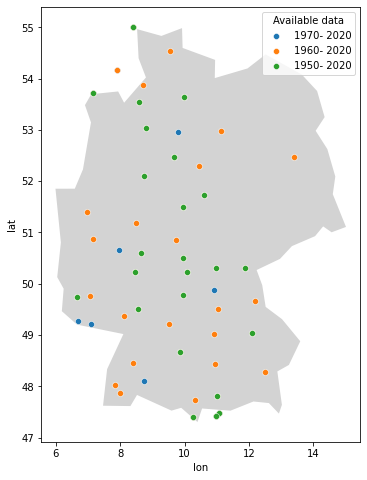

In [5]:
plot_points_germany(dwd_links)

In [6]:
#to_exp = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")
#to_exp.id = to_exp.id.apply(lambda x: str(x).zfill(5))
#to_exp.to_csv("app/coordinates.csv")

#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

### Approximating BBCH for analysis




Q1 quantile of arr :  260.0
Q2 quantile of arr :  269.0
Q3 quantile of arr :  280.0
90% of corn is harvested at :  289.0
95% of corn is harvested at :  295.0
99% of corn is harvested at :  304.0


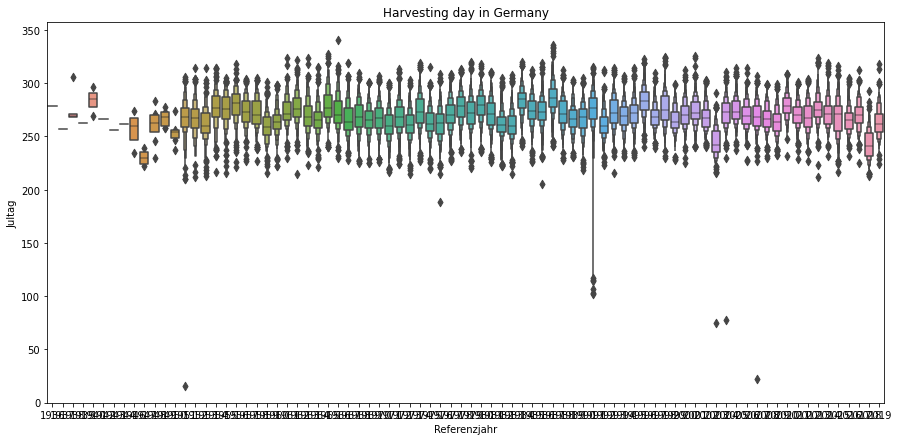

In [7]:
plot_harvest_date_mais()

In [8]:
corn_harvest_date = quantile_date_stage_crop("mais",0.90,24)
wheat_bbch75 = quantile_date_stage_crop("wheat",0.90,19)

wheat_sawing_date = quantile_date_stage_crop("wheat",0.90,10)
wheat_harvest_date = quantile_date_stage_crop("wheat",0.90,23)
print(f"""Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest {corn_harvest_date}
Wheat - bbch75 {wheat_bbch75}

General for wheat:
------------------------
 Sawing date: {wheat_sawing_date}
 Harvest: {wheat_harvest_date}
 """)

Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest 16.10
Wheat - bbch75 20.07

General for wheat:
------------------------
 Sawing date: 27.10
 Harvest: 26.08
 


## Step 2. Obtaining the data and ensuring quality
### 1. Temperature

In [9]:
df_airtemp = download_dwd_data("air_temperature","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)
#Replacing non-existent values
df_airtemp.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


(0.0, 300000.0)

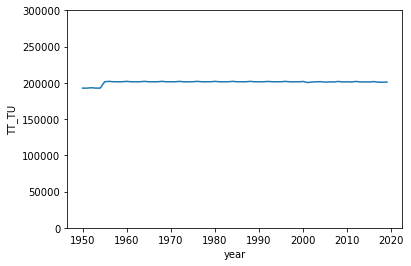

In [10]:
#Step 1. Checking data integrity:

df = df_airtemp.copy()
measures = df.groupby("year").count()
fig = plt.figure()
ax = sns.lineplot(x=measures.index,y=measures.TT_TU)
ax.set_ylim(bottom = 0, top = 300000)


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

### 2. Air humidity (RH)

In [11]:
df_moisture= download_dwd_data("moisture","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing non-existent values
df_moisture.replace(-99.9, np.nan, inplace=True)

All given ids accounted for


Text(0, 0.5, 'Number of measures')

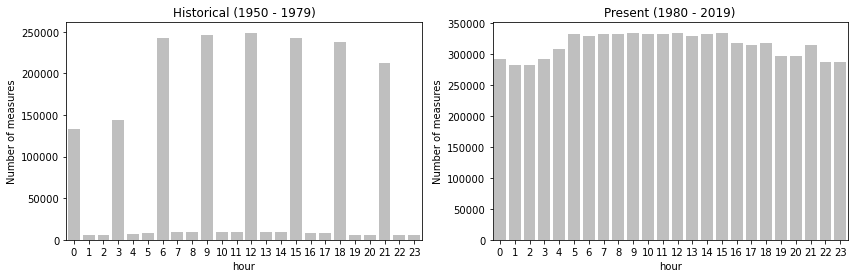

In [12]:
hist_moisture = df_moisture[df_moisture["year"]<1980].groupby("hour").count()
recent_moisture = df_moisture[df_moisture["year"]>=1980].groupby("hour").count()

fig, ax =plt.subplots(1,2,figsize=(14,4))
sns.barplot(x= hist_moisture.index, y = hist_moisture["RF_STD"], color = "0.75", ax= ax[0])
sns.barplot(x= recent_moisture.index, y = recent_moisture["RF_STD"], color = "0.75", ax= ax[1])
ax[0].set_title("Historical (1950 - 1979)")
ax[1].set_title("Present (1980 - 2019)")
ax[0].set_ylabel("Number of measures")
ax[1].set_ylabel("Number of measures")

We can observe from here that in this time period, the relative humidity was mostly measured from 3 to 3 hours, during the working time, as the measuring process was mostly manual.
From 1980, the data is measured more constantly. A solution is to limit the analysis on the hours that are measured.

In [13]:
df_moisture = df_moisture[df_moisture["hour"].isin([6, 9, 12, 15, 18, 21])]

## Step 2. Obtaining the data and ensuring quality
## Fusarium graminearum - air temperature and moisture

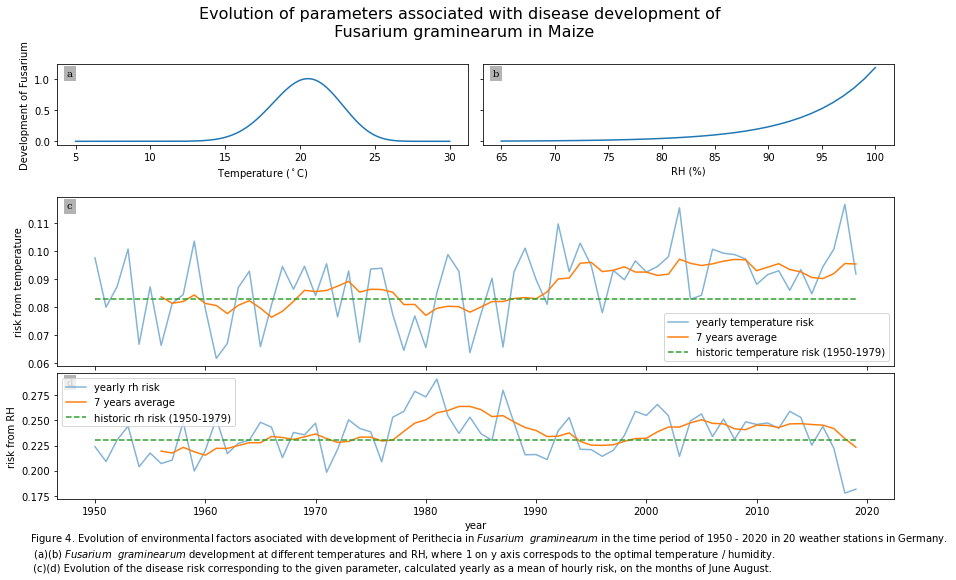

In [14]:
plot_risk_fusarium(df_airtemp, df_moisture,
temp_min=15,temp_max=25,
hist_start=1950,hist_end=1979,
#start_dd_mm="01.09", end_dd_mm="01.05",
start_dd_mm=corn_harvest_date, end_dd_mm=wheat_harvest_date, 
moving_average=7 
)

### Combined risk

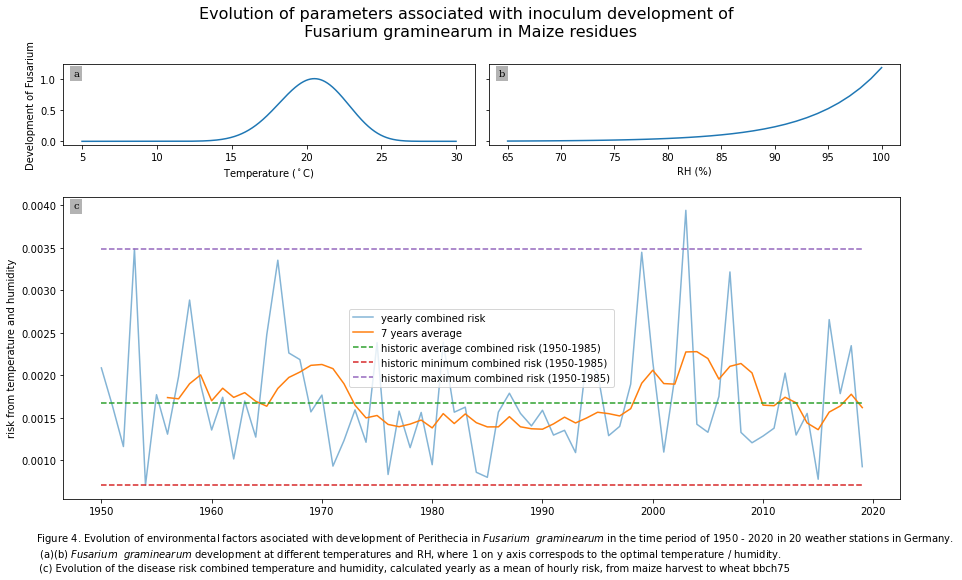

In [15]:
plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75 , hours = [3,6,9,12,15,18,21])

# Making a linear regression

In [16]:

lm_fusarium_t = linear_model_temperature(df_airtemp,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium,year_minus=0)
lm_fusarium_rh = linear_model_moisture(df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium_rh,year_minus=0)

### Combined Risk

In [17]:
from source_code.lm_fusarium import linear_model_combined
lm_fusarium_combined = linear_model_combined(df_airtemp, df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75,func1 = equation_fusarium, func2= equation_fusarium_rh, year_minus=0)

In [18]:
print(lm_fusarium_combined)

   station id   r_value      gradient  intercept   p_value  \
0       01975 -0.132848 -1.017153e-05   0.022138  0.272929   
1       01550 -0.197448 -8.170713e-06   0.017182  0.101340   
2       00691 -0.029247 -1.896654e-06   0.005362  0.810062   
3       05906 -0.189740 -1.886903e-05   0.039916  0.115668   
4       00656 -0.016658 -7.443296e-07   0.002280  0.891135   
5       03730 -0.058803 -2.970012e-06   0.006730  0.628710   
6       00867  0.289195  1.973553e-05  -0.037757  0.015176   
7       01691 -0.294484 -2.432022e-05   0.049986  0.013338   
8       04887 -0.192244 -1.542012e-05   0.031898  0.110851   
9       03631 -0.117848 -9.243108e-06   0.020534  0.331237   
10      02597  0.494727  5.135440e-05  -0.099681  0.000013   
11      05100  0.300619  5.895893e-05  -0.113274  0.014966   
12      05371 -0.105686 -2.773921e-06   0.005902  0.383888   
13      01639  0.312262  2.429734e-05  -0.046482  0.008496   
14      02601  0.255152  1.414426e-05  -0.026751  0.033028   
15      

In [26]:
lm_fusarium_t.to_csv("results/lm_fusarium_t.csv", float_format='%.5f')
lm_fusarium_rh.to_csv("results/lm_fusarium_rh.csv",float_format='%.5f')
lm_fusarium_combined.to_csv("results/lm_fusarium_combined.csv", float_format='%.5f')

### Preparing for .ppt

### Old code, might include this or not

In [19]:
"""
plot_optimal_temperature(df_airtemp, 
    temp_min=15,temp_max=25,
    hist_start=1950,hist_end=1985,
    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
    moving_average=7)"""

'\nplot_optimal_temperature(df_airtemp, \n    temp_min=15,temp_max=25,\n    hist_start=1950,hist_end=1985,\n    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, \n    moving_average=7)'

In [20]:
### Now let's try to plot it only for the hours where we have the measurement value correct
"""plot_lw_RHt(df_moisture,
            thresholds=[87,90,93],
            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
            hist_start=1950,hist_end=1985, 
            hours=[3,6,9,12,15,18,21],
            moving_average=7,
            )"""

'plot_lw_RHt(df_moisture,\n            thresholds=[87,90,93],\n            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, \n            hist_start=1950,hist_end=1985, \n            hours=[3,6,9,12,15,18,21],\n            moving_average=7,\n            )'

### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

In [21]:
"""df_dryness = df_moisture.copy()
plot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)"""

'df_dryness = df_moisture.copy()\nplot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)'

# Leaf wetness model 2

"The difference between T and dew point temperature (Td) is the dew point depression (DPD) which has also been suggested as a LWD estimator by Huber and Gillespie (1992) and Gillespie et al. (1993), based on the same observations done by Monteith (1957) in relation to RH. Duration of wetness is estimated as the length of time that DPD remains between two specific limits. The wetness criteria for this study were DPD ≤ 1.8 °C for wetness onset and DPD ≥ 2.2 °C for wetness dry-off (Rao et al., 1998)."

In [22]:
"""df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing unknown values with np.nan so they will not be counted in the statistic
df_dew_point.replace(-999.0, np.nan, inplace=True)"""

'df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)\n\n#Replacing unknown values with np.nan so they will not be counted in the statistic\ndf_dew_point.replace(-999.0, np.nan, inplace=True)'

In [23]:
#Checking data integrity and quality
"""df_dpd = df_dew_point.copy()
measures = df_dpd.groupby("year").count()
sns.lineplot(x=measures.index,y=measures.TD)
plot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)"""

'df_dpd = df_dew_point.copy()\nmeasures = df_dpd.groupby("year").count()\nsns.lineplot(x=measures.index,y=measures.TD)\nplot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)'